In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import requests

from ipypb import track
from IPython.display import HTML

In [2]:
login_url = 'https://platform.fabriq.space/authentication/login/?next=/'

s = requests.Session()
s.get(login_url)

s.cookies

<RequestsCookieJar[Cookie(version=0, name='csrftoken', value='qt2Cr86pfOFDVYRCpQFU0KtLYUnss6hZoztBX3dT6cncyHUG2d1PbEmNoUG79pRF', port=None, port_specified=False, domain='platform.fabriq.space', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1621265832, discard=False, comment=None, comment_url=None, rest={}, rfc2109=False)]>

In [3]:
from secrets import USERNAME, PASSWORD

headers = {
    'Referer' : login_url,
}

login_data = {
    'csrfmiddlewaretoken' : s.cookies['csrftoken'],
    'username' : USERNAME,
    'password' : PASSWORD,
}

r = s.post(login_url, data=login_data, headers=headers)

r

<Response [200]>

In [4]:
start_dates = pd.date_range('2020-01-01', '2020-05-15', freq='2W')
end_dates = start_dates + pd.Timedelta(weeks=2)

date_pairs = list(zip(start_dates, end_dates))

date_pairs

[(Timestamp('2020-01-05 00:00:00', freq='2W-SUN'),
  Timestamp('2020-01-19 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-01-19 00:00:00', freq='2W-SUN'),
  Timestamp('2020-02-02 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-02-02 00:00:00', freq='2W-SUN'),
  Timestamp('2020-02-16 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-02-16 00:00:00', freq='2W-SUN'),
  Timestamp('2020-03-01 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-03-01 00:00:00', freq='2W-SUN'),
  Timestamp('2020-03-15 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-03-15 00:00:00', freq='2W-SUN'),
  Timestamp('2020-03-29 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-03-29 00:00:00', freq='2W-SUN'),
  Timestamp('2020-04-12 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-04-12 00:00:00', freq='2W-SUN'),
  Timestamp('2020-04-26 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-04-26 00:00:00', freq='2W-SUN'),
  Timestamp('2020-05-10 00:00:00', freq='2W-SUN')),
 (Timestamp('2020-05-10 00:00:00', freq='2W-SUN'),
  Timestamp('2020-05-2

In [5]:
query_2_tq = lambda query: ';'.join([f'{q[0]}:{q[1]}' for q in list(zip(query.keys(), query.values()))])
timestamp_2_date = lambda timestamp: timestamp.strftime('%Y-%m-%d')

def form_query(building_id, start_date, end_date, energy_type='electricity'):
    raw_query = {
        'meter_category' : 'electricity',
        'chart_type' : 'bars',
        'is_stacked' : 'no',
        'metric' : 'consumption',
        'meters' : f'os-atm:{building_id}:{energy_type}',
        'show_mode' : 'portfolio',
        'zoom_level' : 'hour',
        'compare' : 'null',
        'ratio' : 'none',
        'start_date' : timestamp_2_date(start_date),
        'end_date' : timestamp_2_date(end_date),
    }
    
    query = query_2_tq(raw_query)
    
    return query

start_date, end_date = date_pairs[0]
building_id = 12149

query = form_query(building_id, start_date, end_date)

query

'meter_category:electricity;chart_type:bars;is_stacked:no;metric:consumption;meters:os-atm:12149:electricity;show_mode:portfolio;zoom_level:hour;compare:null;ratio:none;start_date:2020-01-05;end_date:2020-01-19'

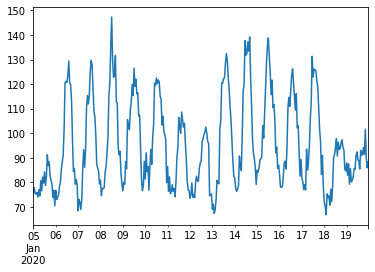

In [6]:
def query_2_data(query):
    portfolio_url = 'https://platform.fabriq.space/portfolio/portfolio_chart/'

    portfolio_params = {
        'tqx' : 'reqId:8',
        'tq' : query,
        'is_initial' : '0',
        'is_enable_saving_state' : '0',
        '_' : '1586602795178',
    }

    r = s.get(portfolio_url, params=portfolio_params)
    r_json = r.json()

    x = pd.to_datetime(r_json['chart_component']['chart']['x_axis']['datetimes'])
    y = r_json['chart_component']['chart']['series'][0]['values']
    s_consumption = pd.Series(y, index=x)
    
    return s_consumption

s_consumption = query_2_data(query)

s_consumption.plot()

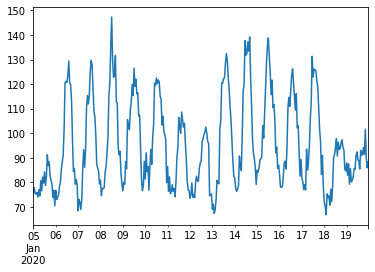

In [7]:
get_building_consumption = lambda building_id, start_date, end_date, energy_type='electricity': query_2_data(form_query(building_id, start_date, end_date, energy_type))
    
start_date, end_date = date_pairs[0]
building_id = 12149

s_consumption = get_building_consumption(building_id, start_date, end_date)

s_consumption.plot()

 [████████████████████████████████████████████████████████████] 10/10 [00:03<00:00, 0.32s/it]

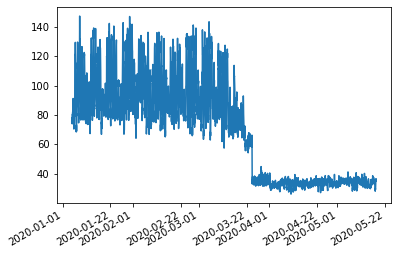

In [8]:
building_id = 12149
s_consumption = pd.Series(dtype='float64')

for start_date, end_date in track(date_pairs):
    s_fortnight_consumption = get_building_consumption(building_id, start_date, end_date)
    s_consumption = s_consumption.append(s_fortnight_consumption)
    
s_consumption = s_consumption.dropna()
s_consumption = s_consumption.astype(float)

s_consumption.plot()

Text(0.5, 1.0, '')

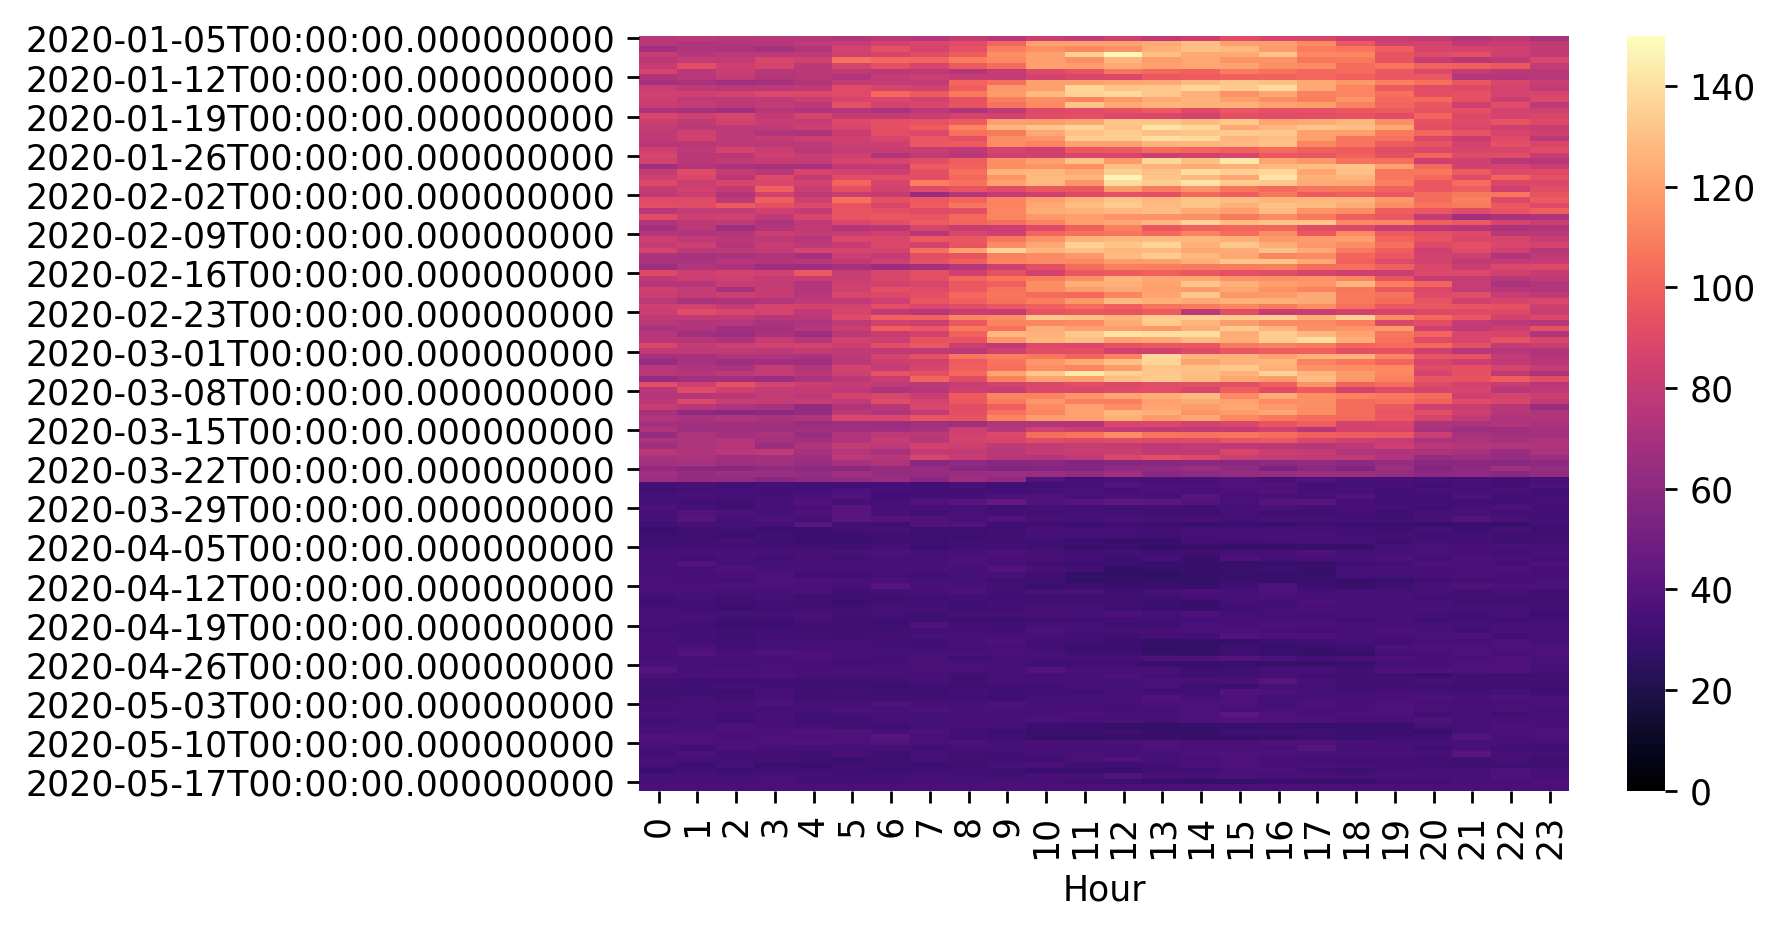

In [9]:
df_consumption_pivot = (s_consumption
                        .copy()
                        .groupby([s_consumption.index.hour, 
                                  s_consumption.index.date])
                        .mean()
                        .reset_index()
                        .rename(columns={'level_0':'hour', 
                                        'level_1':'date',
                                         0:'value'})
                        .pivot('date', 'hour', 'value')
                       )

df_consumption_pivot.index = pd.to_datetime(df_consumption_pivot.index)
df_consumption_pivot.interpolate(axis=1).to_pickle('data/consumption.pkl')

## Plotting
fig, ax = plt.subplots(dpi=250)

sns.heatmap(df_consumption_pivot.interpolate(axis=1), ax=ax, vmin=0, vmax=150, cmap='magma')

ax.set_xlabel('Hour')
ax.set_ylabel('')
ax.set_title('')